# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c67e2964e183e19c4a40de309fc885a5104d002f3314a6ef852b4e603d933fff
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=f1a4510008cfdcf2f36991b1455913b0b04163618d428cfdedbaa664d3e36e70
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = (OutConv(n_filters, n_classes))
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 569: 


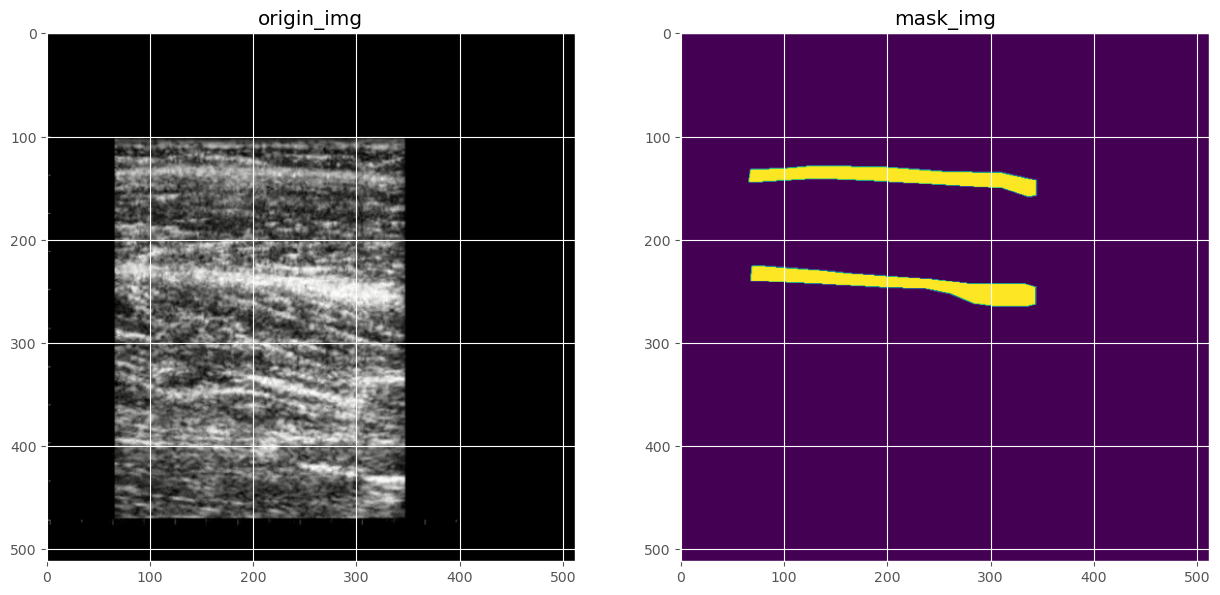

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCELoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
   
    
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)[0]
            dice_score += criterion(mask_pred, mask_true[0].float())
            dice_score += dice_loss(mask_pred, mask_true[0])
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true[0].long(), mode='binary', threshold=0.5)
#             print("tp: {}, fp: {}, fn: {}, tn: {}".format(tp, fp, fn, tn))
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
#             print("iou score: {}".format(iou_score))

    return (dice_score / max(num_val_batches, 1), iou_score)

## 设置wandb账号
用作统计与数据分析

In [10]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin


In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)
dir_checkpoint = Path('./checkpoints/')


def train(model, device, 
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    
     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCELoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
#     iou_metric = smp.metrics.IoU(threshold=0.5),
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
#                     iou = iou_metric(true_masks, (masks_pred > 0.5).float())
#                     if n_classes == 1:
#                         loss = criterion(masks_pred, true_masks.float())
#                         loss += dice_loss(F.sigmoid(masks_pred), true_masks.float(), multiclass=False)
#                     else:
                        
#                         loss = criterion(masks_pred, true_masks)
#                         loss += dice_loss(
#                             F.softmax(masks_pred, dim=1).float(),
#                             F.one_hot(true_masks, n_classes).permute(0, 3, 1, 2).float(),
#                             multiclass=True
#                         )
#                     iou = iou_metric(true_masks, (masks_pred > 0.5).float())
                    
                tp, fp, fn, tn = smp.metrics.get_stats(masks_pred[0], true_masks[0].long(), mode='binary', threshold=0.5)
#               print("tp: {}, fp: {}, fn: {}, tn: {}".format(tp, fp, fn, tn))
                iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    
    train(model, device)

    

Let's use 2 GPUs!


wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231005_035504-48ocaygl
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run atomic-plant-62
wandb: ⭐️ View project at https://wandb.ai/torwayland/U-Net
wandb: 🚀 View run at https://wandb.ai/torwayland/U-Net/runs/48ocaygl
Epoch 60/60: 100%|██████████| 456/456 [02:49<00:00,  2.68img/s, loss (batch)=0.947]


# 推理